In [1]:
import torch
from typing import Tuple, List, Dict, Any, Literal, Optional
from jaxtyping import Float
from pathlib import Path
from einops import rearrange, einsum, repeat
import tqdm
import imageio
import shutil
import sys
# add 
sys.path.append(str(Path().absolute().parent))

from utils.geometry_utils import CameraPose
import os
import numpy as np
from torch.utils.data import DataLoader
from einops import rearrange, repeat
import math
import matplotlib.pyplot as plt
import tqdm
import cv2
import yaml

In [2]:
# initialize data dictionary
data_dict = {}

In [3]:
# helper functions

def compute_pose_rotation_around_x_axis(angle: float) -> Float[torch.Tensor, "4 4"]:
    # input angle in degrees
    P_rot = torch.tensor([
        [1, 0, 0, 0],
        [0, math.cos(angle * (math.pi / 180.0)), -math.sin(angle * (math.pi / 180.0)), 0],
        [0, math.sin(angle * (math.pi / 180.0)), math.cos(angle * (math.pi / 180.0)), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)

    return P_rot

def compute_pose_rotation_around_y_axis(angle: float) -> Float[torch.Tensor, "4 4"]:
    # input angle in degrees
    P_rot = torch.tensor([
        [math.cos(angle * (math.pi / 180.0)), 0, math.sin(angle * (math.pi / 180.0)), 0],
        [0, 1, 0, 0],
        [-math.sin(angle * (math.pi / 180.0)), 0, math.cos(angle * (math.pi / 180.0)), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)

    return P_rot

def compute_pose_rotation_around_z_axis(angle: float) -> Float[torch.Tensor, "4 4"]:
    # input angle in degrees
    P_rot = torch.tensor([
        [math.cos(angle * (math.pi / 180.0)), -math.sin(angle * (math.pi / 180.0)), 0, 0],
        [math.sin(angle * (math.pi / 180.0)), math.cos(angle * (math.pi / 180.0)), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)

    return P_rot

def poses4x4_to_raw(cam2world4x4: Float[torch.Tensor, "N 4 4"], intrinsics: Tuple[float, float, float, float]) -> Float[torch.Tensor, "N 18"]:
    """Convert 4x4 poses to raw poses."""

    world2cam = torch.linalg.inv(cam2world4x4)
    fx, fy, cx, cy = intrinsics

    intrinsics = repeat(torch.tensor([fx, fy, cx, cy, 0, 0]), 'd -> n d', n=world2cam.shape[0])
    world2cam = world2cam[:, :3, :4].reshape(world2cam.shape[0], -1)
    return torch.cat([intrinsics, world2cam], dim=1)

from scipy.ndimage import gaussian_filter1d
from liegroups.numpy import SE3

def smoothen_se3_trajectory(
    poses: Float[np.ndarray, "N 4 4"], 
    sigma: float = 1.0,
) -> Float[np.ndarray, "N 4 4"]:
    
    if sigma == 0:
        return poses

    # Convert raw 4x4 matrices to SE3 objects
    se3_objs = [SE3.from_matrix(pose, normalize=True) for pose in poses]
    
    # Log to tangent space
    twist_vectors = np.array([se3.log() for se3 in se3_objs])  # shape (N, 6)

    # Smooth in tangent space
    smoothed_twists = gaussian_filter1d(twist_vectors, sigma=sigma, axis=0)

    # Map back to SE(3)
    smoothed_se3s = [SE3.exp(twist) for twist in smoothed_twists]
    smoothed_poses = np.array([se3.as_matrix() for se3 in smoothed_se3s])

    return smoothed_poses

def plot_camera_trajectory_topdown(poses, figsize=(10, 10)):
    """
    Plot camera trajectory from a top-down view.
    
    Args:
        poses: List or array of 4x4 camera pose matrices [R, T | 0, 1]
        figsize: Figure size tuple (width, height)
    """
    # Convert poses to numpy array if not already
    poses = np.array(poses)
    
    # Extract camera positions (translation vectors)
    positions = poses[:, :3, 3]
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot trajectory
    plt.plot(positions[:, 0], positions[:, 2], 'b-', label='Camera Path')
    plt.scatter(positions[:, 0], positions[:, 2], c='k', s=50, label='Camera Positions')
    
    # Plot start and end points
    plt.scatter(positions[0, 0], positions[0, 2], c='g', s=100, label='Start')
    plt.scatter(positions[-1, 0], positions[-1, 2], c='y', s=100, label='End')
    
    # Add arrows for camera orientation (flipped 180 degrees)
    arrow_scale = np.abs(positions).max() * 0.1
    for pose in poses:
        pos = pose[:3, 3]
        # Flip the forward direction by using positive z-axis instead of negative
        forward = pose[:3, 2]  # Camera forward direction (flipped)
        plt.arrow(pos[0], pos[2],
                 forward[0] * arrow_scale, forward[2] * arrow_scale,
                 head_width=arrow_scale*0.1, head_length=arrow_scale*0.2,
                 fc='k', ec='k', alpha=0.5)
    
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('Camera Trajectory (Top-Down View)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    
    #return plt.gcf()

def plot_camera_trajectory_topdown_video(poses, figsize=(5.12, 5.12), fps=10):
    """
    Create a video showing the camera trajectory evolving over time from a top-down view.

    Args:
        poses: List or array of 4x4 camera pose matrices [R, T | 0, 1]
        figsize: Figure size tuple (width, height)
        fps: Frames per second for the output video
    Returns:
        List of frames as numpy arrays
    """
    import numpy as np
    import matplotlib.pyplot as plt

    poses = np.array(poses)
    positions = poses[:, :3, 3]

    # Calculate arrow scale based on max position values
    arrow_scale = np.abs(positions).max() * 0.1

    print(arrow_scale)

    # Calculate fixed axis limits based on all positions and arrow length
    padding_factor = 2.
    min_padding = padding_factor * arrow_scale
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    z_min, z_max = positions[:, 2].min(), positions[:, 2].max()
    x_padding = max((x_max - x_min) * 0.1 + padding_factor * arrow_scale, min_padding)
    z_padding = max((z_max - z_min) * 0.1 + padding_factor * arrow_scale, min_padding)
    x_min -= x_padding
    x_max += x_padding
    z_min -= z_padding
    z_max += z_padding

    frames = []
    for t in range(len(poses)):
        plt.figure(figsize=figsize)

        # Plot trajectory up to current frame
        plt.plot(positions[:t+1, 0], positions[:t+1, 2], 'b-', label='Camera Path')

        # Plot previous camera positions in blue
        if t > 0:
            plt.scatter(positions[:t, 0], positions[:t, 2], c='b', s=50)

        # Plot current camera position in red
        plt.scatter(positions[t, 0], positions[t, 2], c='k', s=100, label='Current Position')

        # Plot start and end points
        plt.scatter(positions[0, 0], positions[0, 2], c='g', s=100, label='Start')
        if t == len(poses) - 1:
            plt.scatter(positions[-1, 0], positions[-1, 2], c='y', s=100, label='End')

        # Add arrows for camera orientation up to current frame
        for i in range(t + 1):
            pose = poses[i]
            pos = pose[:3, 3]
            forward = pose[:3, 2]
            if i == t:
                plt.arrow(pos[0], pos[2],
                          forward[0] * arrow_scale, forward[2] * arrow_scale,
                          head_width=arrow_scale*0.15, head_length=arrow_scale*0.3,
                          fc='r', ec='r', alpha=0.8, linewidth=2)
            else:
                plt.arrow(pos[0], pos[2],
                          forward[0] * arrow_scale, forward[2] * arrow_scale,
                          head_width=arrow_scale*0.1, head_length=arrow_scale*0.2,
                          fc='k', ec='k', alpha=0.5)

        plt.xlabel('X')
        plt.ylabel('Z')
        plt.title(f'Camera Trajectory (Top-Down View) - Frame {t+1}/{len(poses)}')
        plt.xlim(x_min, x_max)
        plt.ylim(z_min, z_max)
        plt.grid(True)
        plt.legend()

        fig = plt.gcf()
        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame)
        plt.close()

    return frames

def save_frames_as_video(frames: List[np.ndarray], output_path: str, fps: int = 10):
    """
    Save a list of frames as a video file.
    
    Args:
        frames: List of frames as numpy arrays (RGBA format)
        output_path: Path to save the video file
        fps: Frames per second for the output video
    """
    if not frames:
        raise ValueError("No frames provided")
    
    # Get frame dimensions
    height, width = frames[0].shape[:2]
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Write frames
    for frame in frames:
        # Convert RGBA to BGR (OpenCV format)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        out.write(frame_bgr)
    
    # Release video writer
    out.release() 

def save_video_and_poses(frames, poses, intrinsics, new_folder, video_id, dummy_frame: np.ndarray = None):
    # save the frames

    os.makedirs(os.path.join(new_folder, "test_images", f"{video_id}"), exist_ok=True)

    if dummy_frame is None:
        for i, frame in enumerate(frames):

            # reshape frame to 256x256
            frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_LINEAR)

            cv2.imwrite(os.path.join(new_folder, "test_images", f"{video_id}", f"{i}.jpg"), frame)
    else:
        for i in range(len(poses)):
            frame = dummy_frame
            frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_LINEAR)
            cv2.imwrite(os.path.join(new_folder, "test_images", f"{video_id}", f"{i}.jpg"), frame)
    
    # create a video from the frames with the same codec as the reference file
    video_file = os.path.join(new_folder, "test_256", f"{video_id}.mp4")
    
    # Using imageio with ffmpeg backend to specify h264 codec
    # Set bitrate similar to reference (approximately 1Mbps)
    with imageio.get_writer(video_file, format='FFMPEG', fps=10, codec='h264', 
                          pixelformat='yuv420p', bitrate=1000000, ffmpeg_params=['-pix_fmt', 'yuv420p']) as writer:
        if dummy_frame is None:
            for frame in frames:
                # reshape frame to 256x256
                frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_LINEAR)
                writer.append_data(frame)
        else:
            for _ in range(len(poses)):
                frame = dummy_frame
                frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_LINEAR)
                writer.append_data(frame)

    raw_poses = poses4x4_to_raw(poses, intrinsics)

    # save the poses
    torch.save(raw_poses, os.path.join(new_folder, "test_poses", f"{video_id}.pt"))

    # copy into train_256 and train_poses
    os.makedirs(os.path.join(new_folder, "training_256"), exist_ok=True)
    os.makedirs(os.path.join(new_folder, "training_poses"), exist_ok=True)
    shutil.copy(video_file, os.path.join(new_folder, "training_256", f"{video_id}.mp4"))
    shutil.copy(os.path.join(new_folder, "test_poses", f"{video_id}.pt"), os.path.join(new_folder, "training_poses", f"{video_id}.pt"))

def plot_camera_trajectory_sideview(poses, figsize=(10, 10)):
    """
    Plot camera trajectory from a side view.
    
    Args:
        poses: List or array of 4x4 camera pose matrices [R, T | 0, 1]
        figsize: Figure size tuple (width, height)
    """
    # Convert poses to numpy array if not already
    poses = np.array(poses)
    
    # Extract camera positions (translation vectors)
    positions = poses[:, :3, 3]
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot trajectory (Z vs -Y for side view - flipped Y axis)
    plt.plot(positions[:, 2], -positions[:, 1], 'b-', label='Camera Path')
    plt.scatter(positions[:, 2], -positions[:, 1], c='k', s=50, label='Camera Positions')
    
    # Plot start and end points
    plt.scatter(positions[0, 2], -positions[0, 1], c='g', s=100, label='Start')
    plt.scatter(positions[-1, 2], -positions[-1, 1], c='y', s=100, label='End')
    
    # Add arrows for camera orientation
    arrow_scale = np.abs(positions).max() * 0.1
    for pose in poses:
        pos = pose[:3, 3]
        # Use camera forward direction for side view
        forward = pose[:3, 2]  # Camera forward direction
        plt.arrow(pos[2], -pos[1],
                 forward[2] * arrow_scale, -forward[1] * arrow_scale,
                 head_width=arrow_scale*0.1, head_length=arrow_scale*0.2,
                 fc='k', ec='k', alpha=0.5)
    
    plt.xlabel('Z')
    plt.ylabel('Y')
    plt.title('Camera Trajectory (Side View)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

def plot_camera_trajectory_sideview_video(poses, figsize=(5.12, 5.12), fps=10):
    """
    Create a video showing the camera trajectory evolving over time from a side view.

    Args:
        poses: List or array of 4x4 camera pose matrices [R, T | 0, 1]
        figsize: Figure size tuple (width, height)
        fps: Frames per second for the output video
    Returns:
        List of frames as numpy arrays
    """
    import numpy as np
    import matplotlib.pyplot as plt

    poses = np.array(poses)
    positions = poses[:, :3, 3]

    # Calculate arrow scale based on max position values
    arrow_scale = np.abs(positions).max() * 0.1

    print(arrow_scale)

    # Calculate fixed axis limits based on all positions and arrow length
    padding_factor = 2.
    min_padding = padding_factor * arrow_scale
    z_min, z_max = positions[:, 2].min(), positions[:, 2].max()
    y_min, y_max = -positions[:, 1].max(), -positions[:, 1].min()  # Flip Y limits
    z_padding = max((z_max - z_min) * 0.1 + padding_factor * arrow_scale, min_padding)
    y_padding = max((y_max - y_min) * 0.1 + padding_factor * arrow_scale, min_padding)
    z_min -= z_padding
    z_max += z_padding
    y_min -= y_padding
    y_max += y_padding

    frames = []
    for t in range(len(poses)):
        plt.figure(figsize=figsize)

        # Plot trajectory up to current frame (Z vs -Y for side view - flipped Y axis)
        plt.plot(positions[:t+1, 2], -positions[:t+1, 1], 'b-', label='Camera Path')

        # Plot previous camera positions in blue
        if t > 0:
            plt.scatter(positions[:t, 2], -positions[:t, 1], c='b', s=50)

        # Plot current camera position in red
        plt.scatter(positions[t, 2], -positions[t, 1], c='k', s=100, label='Current Position')

        # Plot start and end points
        plt.scatter(positions[0, 2], -positions[0, 1], c='g', s=100, label='Start')
        if t == len(poses) - 1:
            plt.scatter(positions[-1, 2], -positions[-1, 1], c='y', s=100, label='End')

        # Add arrows for camera orientation up to current frame
        for i in range(t + 1):
            pose = poses[i]
            pos = pose[:3, 3]
            forward = pose[:3, 2]
            if i == t:
                plt.arrow(pos[2], -pos[1],
                          forward[2] * arrow_scale, -forward[1] * arrow_scale,
                          head_width=arrow_scale*0.15, head_length=arrow_scale*0.3,
                          fc='r', ec='r', alpha=0.8, linewidth=2)
            else:
                plt.arrow(pos[2], -pos[1],
                          forward[2] * arrow_scale, -forward[1] * arrow_scale,
                          head_width=arrow_scale*0.1, head_length=arrow_scale*0.2,
                          fc='k', ec='k', alpha=0.5)

        plt.xlabel('Z')
        plt.ylabel('Y')
        plt.title(f'Camera Trajectory (Side View) - Frame {t+1}/{len(poses)}')
        plt.xlim(z_min, z_max)
        plt.ylim(y_min, y_max)
        plt.grid(True)
        plt.legend()

        fig = plt.gcf()
        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame)
        plt.close()

    return frames

def plot_camera_trajectory_3dview(poses, figsize=(10, 10)):
    """
    Plot camera trajectory from a 3D view (azimuth=45°, elevation=45°), with y-axis as vertical.

    Args:
        poses: List or array of 4x4 camera pose matrices [R, T | 0, 1]
        figsize: Figure size tuple (width, height)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    poses = np.array(poses)
    positions = poses[:, :3, 3]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # X: positions[:, 0], Y: positions[:, 2], Z: positions[:, 1] (vertical) - flipped y-axis
    ax.plot(positions[:, 0], positions[:, 2], -positions[:, 1], 'b-', label='Camera Path')
    ax.scatter(positions[:, 0], positions[:, 2], -positions[:, 1], c='k', s=50, label='Camera Positions')

    # Start and end points
    ax.scatter(positions[0, 0], positions[0, 2], -positions[0, 1], c='g', s=100, label='Start')
    ax.scatter(positions[-1, 0], positions[-1, 2], -positions[-1, 1], c='y', s=100, label='End')

    # Arrows for camera orientation
    arrow_scale = np.abs(positions).max() * 0.1
    for pose in poses:
        pos = pose[:3, 3]
        forward = pose[:3, 2]
        ax.quiver(pos[0], pos[2], -pos[1],
                  forward[0], forward[2], -forward[1],
                  length=arrow_scale, color='k', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y (vertical)')
    ax.set_title('Camera Trajectory (3D View, Azimuth=45°, Elevation=45°)')
    ax.view_init(elev=45, azim=45)
    ax.legend()
    plt.show()

def plot_camera_trajectory_3dview_video(poses, figsize=(5.12, 5.12), fps=10):
    """
    Create a video showing the camera trajectory evolving over time from a 3D view (azimuth=45°, elevation=45°), with y-axis as vertical.

    Args:
        poses: List or array of 4x4 camera pose matrices [R, T | 0, 1]
        figsize: Figure size tuple (width, height)
        fps: Frames per second for the output video
    Returns:
        List of frames as numpy arrays
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    poses = np.array(poses)
    positions = poses[:, :3, 3]

    arrow_scale = np.abs(positions).max() * 0.1

    # Axis limits with padding
    padding = arrow_scale * 2
    x_min, x_max = positions[:, 0].min() - padding, positions[:, 0].max() + padding
    z_min, z_max = positions[:, 2].min() - padding, positions[:, 2].max() + padding
    y_min, y_max = -positions[:, 1].max() - padding, -positions[:, 1].min() + padding  # Flipped y-axis limits

    frames = []
    for t in range(len(poses)):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')

        # X: positions[:, 0], Y: positions[:, 2], Z: positions[:, 1] (vertical) - flipped y-axis
        ax.plot(positions[:t+1, 0], positions[:t+1, 2], -positions[:t+1, 1], 'b-', label='Camera Path')
        if t > 0:
            ax.scatter(positions[:t, 0], positions[:t, 2], -positions[:t, 1], c='b', s=50)
        ax.scatter(positions[t, 0], positions[t, 2], -positions[t, 1], c='k', s=100, label='Current Position')
        ax.scatter(positions[0, 0], positions[0, 2], -positions[0, 1], c='g', s=100, label='Start')
        if t == len(poses) - 1:
            ax.scatter(positions[-1, 0], positions[-1, 2], -positions[-1, 1], c='y', s=100, label='End')

        # Arrows for camera orientation up to current frame
        for i in range(t + 1):
            pose = poses[i]
            pos = pose[:3, 3]
            forward = pose[:3, 2]
            color = 'r' if i == t else 'k'
            alpha = 0.8 if i == t else 0.5
            ax.quiver(pos[0], pos[2], -pos[1],
                      forward[0], forward[2], -forward[1],
                      length=arrow_scale, color=color, alpha=alpha)

        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y (vertical)')
        ax.set_title(f'Camera Trajectory (3D View) - Frame {t+1}/{len(poses)}')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(z_min, z_max)
        ax.set_zlim(y_min, y_max)
        ax.view_init(elev=45, azim=45)
        ax.legend()

        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame)
        plt.close()

    return frames

In [4]:
# generate trajectories

def generate_trajectory_panorama(
    num_frames: int,
    height: float,                  # y-axis coordinate of camera center
    target_rotation_angle: float,          # target rotation angle of camera (degrees)
) -> Float[torch.Tensor, "N 4 4"]: 
    """
    Create a cam2world trajectory depicting a panorama - a camera rotation around the y-axis (i.e. rotation in the xz plane) for "rotation_angle" degrees.
    """
    angles = torch.linspace(0, target_rotation_angle, num_frames)       # in degrees
    # rotation angles in radians
    angles_rad = angles * (torch.pi / 180.0)                            # in radians
    
    # create cam2world matrices
    cam2worlds = []
    for angle in angles_rad:
        # Create rotation matrix for x,z plane rotation
        R_rot = torch.tensor([
            [torch.cos(angle), 0, -torch.sin(angle)],
            [0, 1, 0],
            [torch.sin(angle), 0, torch.cos(angle)]
        ], dtype=torch.float32)
        
        # Create new pose matrix (keep same translation)
        cam2world = torch.eye(4, dtype=torch.float32)
        cam2world[:3, :3] = R_rot
        cam2world[:3, 3] = torch.tensor([0, height, 0], dtype=torch.float32)        # set y-coordinate of camera center to be designated height
        
        cam2worlds.append(cam2world)
    
    # Combine original and new poses
    cam2worlds = torch.stack(cam2worlds)

    return cam2worlds

"""
def generate_trajectory_circle(
    num_frames: int,
    height: float,
    radius: float,
    target_rotation_angle: float,
    normalize_wrt_first_frame: bool = True,
) -> Float[torch.Tensor, "N 4 4"]:
    # Create a cam2world trajectory that traces a circle in the xz plane.
    # The camera faces in a direction tangent to the circle.
    
    angles = torch.linspace(0, target_rotation_angle, num_frames)       # in degrees
    # rotation angles in radians
    angles_rad = angles * (torch.pi / 180.0)                            # in radians

    # create cam2world matrices
    cam2worlds = []
    for angle in angles_rad:
        # Create new pose matrix (keep same translation)
        cam2world = torch.eye(4, dtype=torch.float32)
        
        # compute camera orientation
        # Create rotation matrix for x,z plane rotation
        angle += torch.pi / 2.0                             # add 90 degrees to face tangent to the circle
        R_rot = torch.tensor([
            [torch.cos(angle), 0, -torch.sin(angle)],
            [0, 1, 0],
            [torch.sin(angle), 0, torch.cos(angle)]
        ], dtype=torch.float32)
        cam2world[:3, :3] = R_rot

        # compute camera position

        cam2world[:3, 3] = torch.tensor([radius*torch.cos(angle) , height, radius*torch.sin(angle)], dtype=torch.float32)        # set y-coordinate of camera center to be designated height
        
        cam2worlds.append(cam2world)
    
    # Combine original and new poses
    cam2worlds = torch.stack(cam2worlds)

    if normalize_wrt_first_frame:
        cam2worlds = torch.linalg.inv(cam2worlds[0:1]) @ cam2worlds

    return cam2worlds
"""

def generate_trajectory_circle(
    num_frames: int,
    height: float,
    radius: float,
    target_rotation_angle: float,
    normalize_wrt_first_frame: bool = True,
    is_counterclockwise: bool = True,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Create a cam2world trajectory that traces a circle in the xz plane.
    The camera faces in a direction tangent to the circle.
    
    Args:
        num_frames: Number of frames in the trajectory
        height: Y-coordinate of the camera center
        radius: Radius of the circle
        target_rotation_angle: Target rotation angle in degrees
        normalize_wrt_first_frame: Whether to normalize poses relative to first frame
        is_counterclockwise: If True, generate counterclockwise trajectory; if False, generate clockwise trajectory
    """
    
    angles = torch.linspace(0, target_rotation_angle, num_frames)       # in degrees
    # rotation angles in radians
    angles_rad = angles * (torch.pi / 180.0)                            # in radians

    # create cam2world matrices
    cam2worlds = []
    for angle in angles_rad:
        # Create new pose matrix (keep same translation)
        cam2world = torch.eye(4, dtype=torch.float32)
        
        # compute camera position first
        if is_counterclockwise:
            # Counterclockwise: standard circle
            cam2world[:3, 3] = torch.tensor([radius*torch.cos(angle), height, radius*torch.sin(angle)], dtype=torch.float32)
            # For counterclockwise motion, tangent direction is (-sin(angle), 0, cos(angle))
            # This is the derivative of the position with respect to angle
            tangent_x = -torch.sin(angle)
            tangent_z = torch.cos(angle)
        else:
            # Clockwise: reverse the circle direction
            cam2world[:3, 3] = torch.tensor([radius*torch.cos(angle), height, -radius*torch.sin(angle)], dtype=torch.float32)
            # For clockwise motion, tangent direction is (sin(angle), 0, -cos(angle))
            # This is the negative of the counterclockwise tangent
            tangent_x = -torch.sin(angle)
            tangent_z = -torch.cos(angle)
        
        # compute camera orientation to face tangent to the trajectory
        # Forward direction is the tangent vector
        forward = torch.tensor([tangent_x, 0.0, tangent_z], dtype=torch.float32)
        forward = forward / torch.norm(forward)
        
        # Up direction is always (0, 1, 0)
        up = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32)
        
        # Right direction is up cross forward
        right = torch.cross(up, forward)
        right = right / torch.norm(right)
        
        # Recompute up to ensure orthogonality
        up = torch.cross(forward, right)
        
        # Create rotation matrix
        R = torch.stack([right, up, forward], dim=1)  # each vector is a column
        cam2world[:3, :3] = R
        
        cam2worlds.append(cam2world)
    
    # Combine original and new poses
    cam2worlds = torch.stack(cam2worlds)

    if normalize_wrt_first_frame:
        cam2worlds = torch.linalg.inv(cam2worlds[0:1]) @ cam2worlds

    return cam2worlds

def generate_trajectory_orbit(
    num_frames: int,
    height: float,                              # y-axis coordinate of camera center
    start_rotation_angle: float = 0,            # start rotation angle of camera (degrees)
    target_rotation_angle: float = 360,         # target rotation angle of camera (degrees)
    radius: float = 0.5,                        # radius of circular orbit
    normalize_wrt_first_frame: bool = False,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Create a cam2world trajectory depicting an orbital motion - camera moves in a circular path in the xz plane
    while always looking at the center point (0,height,0).
    """
    angles = torch.linspace(start_rotation_angle, target_rotation_angle, num_frames)  # in degrees
    angles_rad = angles * (torch.pi / 180.0)                       # in radians
    
    # create cam2world matrices
    cam2worlds = []
    for angle in angles_rad:
        # Calculate camera position on the circle
        cam_x = radius * torch.cos(angle)
        cam_z = radius * torch.sin(angle)
        cam_pos = torch.tensor([cam_x, height, cam_z], dtype=torch.float32)
        
        # Calculate rotation matrix to look at center
        # Forward direction = center - cam_pos (normalized)
        forward = -cam_pos  # looking at origin
        forward[1] = 0      # zero out y component
        forward = forward / torch.norm(forward)
        
        # Right direction = up cross forward
        up = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32)
        right = torch.cross(up, forward)
        right = right / torch.norm(right)
        
        # Recompute up to ensure orthogonality
        up = torch.cross(forward, right)
        
        # Create rotation matrix
        R = torch.stack([right, up, forward], dim=1)  # each vector is a row
        
        # Create full pose matrix
        cam2world = torch.eye(4, dtype=torch.float32)
        cam2world[:3, :3] = R
        cam2world[:3, 3] = cam_pos
        
        cam2worlds.append(cam2world)
    
    # Combine poses
    cam2worlds = torch.stack(cam2worlds)
    
    if normalize_wrt_first_frame:
        cam2worlds = torch.linalg.solve(cam2worlds[0:1], cam2worlds)

    return cam2worlds

def generate_trajectory_forward_backward(
    num_frames_forward: int,
    height: float,
    step_size: float,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Create a cam2world trajectory depicting a forward-backward motion: this means forward for "num_frames_forward" frames, then do a 180 -degree turn and come back to the original position .
    """
    
    cam2world = torch.eye(4, dtype=torch.float32)
    cam2worlds = repeat(cam2world, "i j -> t i j", t=num_frames_forward * 2).contiguous()

    # modify translation
    translation = torch.arange(num_frames_forward) * step_size

    translation = torch.cat([translation, torch.flip(translation, dims=[0])])       # translation along z-axis
    cam2worlds[:, 2, 3] = translation

    # modify rotation
    angles_rad = torch.tensor([0] * num_frames_forward + [math.pi] * num_frames_forward)     # shape = (T,)
    for i, angle in enumerate(angles_rad):
        # Create rotation matrix for x,z plane rotation
        R_rot = torch.tensor([
            [torch.cos(angle), 0, -torch.sin(angle)],
            [0, 1, 0],
            [torch.sin(angle), 0, torch.cos(angle)]
        ], dtype=torch.float32)
        cam2worlds[i, :3, :3] = R_rot

    cam2worlds[:, 1, 3] = height

    return cam2worlds

# function for generating straight line trajectory
def generate_trajectory_straight_line(
    num_frames: int,
    step_size: float = 0.05,
    height: float = 1.5,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Create a cam2world trajectory depicting a straight line along the z-axis
    """
    
    cam2worlds = repeat(torch.eye(4), "i j -> t i j", t=num_frames).contiguous()
    cam2worlds[:, 2, 3] = torch.linspace(0, step_size * (num_frames - 1), num_frames)

    # we want the viewing angle to the trajectory to be "viewing_angle_rel_traj" degrees
    # e.g. for viewing_angle_rel_traj = -5, we want the viewing angle to be 5 degrees "downwards" i.e. rotation about x-axis by -5 degrees
    #head_pose = compute_pose_rotation_around_x_axis(-viewing_angle_rel_traj)
    #cam2worlds[:, :3, :3] = repeat(head_pose[:3, :3], "i j -> t i j", t=num_frames).contiguous()

    return cam2worlds

# function for generating indefinite staircase trajectory
# in order for the finite-context-length diffusion model to know that the conditioning camera trajectory corresponds to a staircase, we generate trajectory comprised of alternating segments of inclined and horizontal portions.
# this is because the conditioning camera trajectory is normalized w.r.t. first frame, and if the infinite staircase trajectory is just a straight line with the same heading angle, then for the intermediate segments the model may just as well interpret that segment as a traversal along the ground in a straight line.
# let's start off with a straight line segment
# then add the user-defined number of stair segments, where we define one segment as an inclined segment followed by a horizontal segment

def generate_trajectory_staircase_segment(
    num_frames_per_inclied_segment: int,
    num_frames_per_horizontal_segment: int,
    inclination_angle: float = 30,          # in degrees
    step_size: float = 0.05,
    height: float = 1.5,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Create a cam2world trajectory depicting a single segment of an indefinite staircase.
    This single staircase segment is comprised of an inclined segment followed by a horizontal segment.
    """

    # generate the inclined segment (poses relative to the first frame of the inclined segment)
    inclined_segment = generate_trajectory_straight_line(num_frames_per_inclied_segment, step_size, height)
    
    # generate the horizontal segment (poses relative to the first frame of the horizontal segment)
    horizontal_segment = generate_trajectory_straight_line(num_frames_per_horizontal_segment, step_size, height)
    
    # transform the horizontal segment to the coordinate frame of the first pose of the inclined segment (within this method, we'll refer to this as the "world frame")
    # cam2world = last_frame_of_inclined_segment2world (<- THIS IS GIVEN BY "inclined_segment[-1]") @ first_frame_of_horizontal_segment2last_frame_of_inclined_segment @ cam2first_frame_of_horizontal_segment (<- THIS IS GIVEN BY "horizontal_segment")
    # first_frame_of_horizontal_segment2last_frame_of_inclined_segment involves a rotation around the x-axis by inclination_angle degrees

    # compute the rotation matrix for the rotation around the x-axis by inclination_angle degrees 
    # if we want to go up the stairs, we want to rotate by a negative angle
    # if we want to go down the stairs, we want to rotate by a positive angle
    # to make it intuitive, we'll at a negative sign in front of the inclination_angle
    # s.t. inclination_angle = 30 degrees means we're going up the stairs
    # and inclination_angle = -30 degrees means we're going down the stairs
    first_frame_of_horizontal_segment2last_frame_of_inclined_segment = compute_pose_rotation_around_x_axis(-inclination_angle)
    horizontal_segment_in_world_frame = repeat(inclined_segment[-1], 'i j -> t i j', t=num_frames_per_horizontal_segment).contiguous() @ repeat(first_frame_of_horizontal_segment2last_frame_of_inclined_segment, 'i j -> t i j', t=num_frames_per_horizontal_segment).contiguous() @ horizontal_segment

    concat_traj = torch.cat([inclined_segment, horizontal_segment_in_world_frame], dim=0)

    return concat_traj

def generate_trajectory_staircase(
    num_frames_start_end_straight_segment: int,
    num_stair_segments: int,
    num_frames_per_inclined_segment: int,
    num_frames_per_horizontal_segment: int,
    inclination_angle: float = 30,          # in degrees
    step_size: float = 0.05,
    height: float = 1.5,
    different_viewing_angle: bool = False,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Create a cam2world trajectory depicting an indefinite staircase.
    """

    segments = []

    # generate the first segment at the bottom of the staircase, which is a straight line segment
    initial_straight_segment = generate_trajectory_straight_line(num_frames_start_end_straight_segment, 2 * step_size, height)
    segments.append(initial_straight_segment)

    # generate the stair segments
    for i in range(num_stair_segments):
        latest_segment = segments[-1]      # shape = (T, 4, 4)

        # generate the inclined segment containing camera poses relative to the first frame of the inclined segment
        current_segment_rel_first = generate_trajectory_staircase_segment(num_frames_per_inclined_segment, num_frames_per_horizontal_segment, inclination_angle, step_size, height)

        # compute the rotation matrix for the rotation around the x-axis by "inclination_angle" degrees
        # if we want to go up the stairs, we want to rotate by a negative angle
        # if we want to go down the stairs, we want to rotate by a positive angle
        first_frame_of_current_segment2last_frame_of_previous_segment = compute_pose_rotation_around_x_axis(inclination_angle)
    
        current_segment_rel_world = repeat(latest_segment[-1], 'i j -> t i j', t=num_frames_per_inclined_segment + num_frames_per_horizontal_segment).contiguous() @ repeat(first_frame_of_current_segment2last_frame_of_previous_segment, 'i j -> t i j', t=num_frames_per_inclined_segment + num_frames_per_horizontal_segment).contiguous() @ current_segment_rel_first

        segments.append(current_segment_rel_world)

    # generate the final segment at the top of the staircase, which is a straight line segment
    latest_segment = segments[-1]      # shape = (T, 4, 4)
    final_straight_segment_rel_first = generate_trajectory_straight_line(num_frames_start_end_straight_segment, 2 * step_size, height)

    final_straight_segment_rel_world = repeat(segments[-1][-1], 'i j -> t i j', t=num_frames_start_end_straight_segment).contiguous() @ final_straight_segment_rel_first

    segments.append(final_straight_segment_rel_world)

    # every odd-indexed segment is going up the stairs (minus the final segment)
    # rotate the pose in every odd-indexed segment by -inclination_angle / 2 degrees
    if different_viewing_angle:
        for i in range(1, len(segments), 2):
            segments[i][:-num_frames_per_horizontal_segment] = segments[i][:-num_frames_per_horizontal_segment] @ compute_pose_rotation_around_x_axis(-inclination_angle / 2)[None]

    staircase_trajectory = torch.cat(segments, dim=0)

    return staircase_trajectory

def append_trajectory(cam2worlds, trajectory, traj2start_to_traj1end=None, remove_overlapping_frames=False):
    """
    Append a trajectory to the end of of an existing cam2world trajectory where we assume
    1) the existing trajectory (cam2worlds) is defined w.r.t. its first frame (i.e. the world frame)
    2) and that the first frame of the new trajectory is related to the last frame of the existing trajectory by the user-defined transform "traj2start_to_traj1end"
    
    INPUTS:
    cam2worlds: tensor of shape (N, 4, 4) denoting a trajectory of camera poses defined w.r.t. the first frame "cam2worlds"
    trajectory: tensor of shape (M, 4, 4) denoting a trajectory of camera poses defined w.r.t. the first frame "trajectory"
    traj2start_to_traj1end: tensor of shape (4, 4) denoting the transform from the last frame of "cam2worlds" to the first frame of "trajectory"
    remove_overlapping_frames: bool denoting whether to remove overlapping frames between "cam2worlds" and "trajectory"

    RETURNS:
    cam2worlds: tensor of shape (N+M, 4, 4) denoting the concatenation of "cam2worlds" and "trajectory"
    """
    device = cam2worlds.device
    N = cam2worlds.shape[0]

    if traj2start_to_traj1end is None:
        traj2start_to_traj1end = torch.eye(4)[None].to(device)

    # convert trajectory to world frame
    trajectory_world = cam2worlds[N-1:N] @ (traj2start_to_traj1end @ trajectory)

    if remove_overlapping_frames:
        cam2worlds = cam2worlds[:-1]

    return torch.cat([cam2worlds, trajectory_world], dim=0)

def generate_trajectory_forward_rotate_backward(
    num_frames_forward: int,
    num_frames_rotate: int,
    step_size: float,
    height: float,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Generate a trajectory that goes forward, rotates, and then goes backward.
    """
    # generate the forward trajectory
    forward_segment = generate_trajectory_straight_line(num_frames_forward, step_size, height)
    
    # generate the rotate trajectory
    rotate_segment = generate_trajectory_panorama(num_frames_rotate, height, 180)
    
    # generate the backward trajectory
    backward_segment = generate_trajectory_straight_line(num_frames_forward, step_size, height)

    cam2worlds = forward_segment
    cam2worlds = append_trajectory(cam2worlds, rotate_segment)
    cam2worlds = append_trajectory(cam2worlds, backward_segment)

    return cam2worlds

def generate_trajectory_forward_orbit_backward(
    num_frames_forward: int,
    num_frames_orbit: int,
    num_frames_backward: int,
    step_size: float,
    height: float,
    orbit_radius: float,
    remove_overlapping_frames: bool = False,
) -> Float[torch.Tensor, "N 4 4"]:
    """
    Generate a trajectory that goes forward, orbits, and then goes backward.
    """
    # generate the forward trajectory
    forward_segment = generate_trajectory_straight_line(num_frames_forward, step_size, height)
    
    # generate the orbit trajectory
    orbit_segment = generate_trajectory_orbit(num_frames_orbit, height, 180, radius=orbit_radius, normalize_wrt_first_frame=True)
    
    # generate the backward trajectory
    backward_segment = generate_trajectory_straight_line(num_frames_backward, step_size, height)

    cam2worlds = forward_segment
    cam2worlds = append_trajectory(cam2worlds, orbit_segment, remove_overlapping_frames=remove_overlapping_frames)
    cam2worlds = append_trajectory(cam2worlds, backward_segment, remove_overlapping_frames=remove_overlapping_frames)

    return cam2worlds

In [ ]:
# generate 1-loop panorama
num_frames = 24
height = 1.5
target_rotation_angle = 360 - 360 / num_frames

panorama_trajectory = generate_trajectory_panorama(num_frames = num_frames, height = height, target_rotation_angle = target_rotation_angle)

# visualize trajectory
plot_camera_trajectory_topdown(panorama_trajectory)

# save trajectory as a video
frames = plot_camera_trajectory_topdown_video(panorama_trajectory)

# save frames as video
name = "panorama_targetangle{}_{}frames_height{}".format(str(round(target_rotation_angle, 2)).replace(".", "p"), num_frames, str(round(height, 2)).replace(".", "p"))
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))

# save to data_dict
data_dict[name] = (frames, panorama_trajectory)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# generate 2-loop panorama
num_frames = 48
height = 1.5
target_rotation_angle = 720 - 720 / num_frames

panorama_trajectory = generate_trajectory_panorama(num_frames = num_frames, height = height, target_rotation_angle = target_rotation_angle)

# visualize trajectory
plot_camera_trajectory_topdown(panorama_trajectory)

# save trajectory as a video
frames = plot_camera_trajectory_topdown_video(panorama_trajectory)

# save frames as video
name = "panorama_targetangle{}_{}frames_height{}".format(str(round(target_rotation_angle, 2)).replace(".", "p"), num_frames, str(round(height, 2)).replace(".", "p"))
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))

# save to data_dict
data_dict[name] = (frames, panorama_trajectory)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# generate 1-loop circle
num_frames = 24
height = 1.5
radius = 1.5
target_rotation_angle = 360 - 360 / num_frames

circle_trajectory = generate_trajectory_circle(num_frames = num_frames, height = height, radius = radius, target_rotation_angle = target_rotation_angle)

# visualize trajectory
plot_camera_trajectory_topdown(circle_trajectory)

# save trajectory as a video
frames = plot_camera_trajectory_topdown_video(circle_trajectory)

# save frames as video
name = "circle_targetangle{}_{}frames_height{}_radius{}".format(str(round(target_rotation_angle, 2)).replace(".", "p"), num_frames, str(round(height, 2)).replace(".", "p"), str(round(radius, 2)).replace(".", "p"))
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))

# save to data_dict
data_dict[name] = (frames, circle_trajectory)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# generate 2-loop circle
num_frames = 48
height = 1.5
radius = 1.5
target_rotation_angle = 720 - 720 / num_frames

circle_trajectory = generate_trajectory_circle(num_frames = num_frames, height = height, radius = radius, target_rotation_angle = target_rotation_angle)

# visualize trajectory
plot_camera_trajectory_topdown(circle_trajectory)

# save trajectory as a video
frames = plot_camera_trajectory_topdown_video(circle_trajectory)

# save frames as video
name = "circle_targetangle{}_{}frames_height{}_radius{}".format(str(round(target_rotation_angle, 2)).replace(".", "p"), num_frames, str(round(height, 2)).replace(".", "p"), str(round(radius, 2)).replace(".", "p"))
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))

# save to data_dict
data_dict[name] = (frames, circle_trajectory)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# single up the stairs
# parameters for staircase segment (up the stairs)
scale_factor = 1.6
base_step_size = 0.25
base_circular_arc_radius = 0.5

#num_frames_start_end_straight_segment = 10
num_frames_start_end_straight_segment = 15
num_stair_segments = 1
step_size = base_step_size * scale_factor
num_frames_per_inclined_segment = 16
num_frames_per_horizontal_segment = 2
height = 0   
inclination_angle = 30
viewing_angle_rel_traj = 0
sigma = 1.0
different_viewing_angle = True

#
up_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, inclination_angle, step_size, height, different_viewing_angle)

up_the_stairs = smoothen_se3_trajectory(up_the_stairs.cpu().numpy(), sigma=sigma)
up_the_stairs = torch.from_numpy(up_the_stairs).float()

# visualize trajectory
plot_camera_trajectory_sideview(up_the_stairs)

# save trajectory as a video
frames = plot_camera_trajectory_topdown_video(up_the_stairs)

# save frames as video
name = "up_the_stairs_nframes{}_inclinationangle{}_stepsize{}_sigma{}_height{}_{}".format(len(up_the_stairs), str(round(inclination_angle, 2)).replace(".", "p"), str(round(step_size, 2)).replace(".", "p"), str(round(sigma, 2)).replace(".", "p"), str(round(height, 2)).replace(".", "p"), "differentviewingangle" if different_viewing_angle else "sameviewingangle")
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))

# save to data_dict
data_dict[name] = (frames, up_the_stairs)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# staircase circuit trajectory with greater step size
# generate 4-sided circuit with the following features:
# 1) the first side features a trajectory going up the stairs
# 2) the second side features a straight line trajectory
# 3) the third side features a trajectory going down the stairs
# 4) the fourth side features a straight line trajectory
# consecutive sides are connected by a small circular arc of 90 degrees of a user-defined radius

# parameters for staircase segment (up the stairs)
scale_factor = 1.6
base_step_size = 0.25
base_circular_arc_radius = 0.5

num_frames_start_end_straight_segment = 11
num_stair_segments = 1
step_size = base_step_size * scale_factor
num_frames_per_inclined_segment = 11
num_frames_per_horizontal_segment = 1
height = 0   
inclination_angle = 30
viewing_angle_rel_traj = 0
sigma = 1
different_viewing_angle = True

#
up_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, inclination_angle, step_size, height, different_viewing_angle)

up_the_stairs = smoothen_se3_trajectory(up_the_stairs.cpu().numpy(), sigma=sigma)
up_the_stairs = torch.from_numpy(up_the_stairs).float()

down_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, -inclination_angle, step_size, height, different_viewing_angle)

down_the_stairs = smoothen_se3_trajectory(down_the_stairs.cpu().numpy(), sigma=sigma)
down_the_stairs = torch.from_numpy(down_the_stairs).float()

# parameters for straight line segment
num_frames_straight_line = 12
#
straight_line = generate_trajectory_straight_line(num_frames=num_frames_straight_line, step_size=step_size, height=height)
# straight line (half)
straight_line_half = generate_trajectory_straight_line(num_frames=num_frames_straight_line//2, step_size=step_size, height=height)
straight_line_final = generate_trajectory_straight_line(num_frames=num_frames_straight_line//2+3, step_size=step_size, height=height)

# parameters for circular arc segment
circular_arc_radius = base_circular_arc_radius * scale_factor
num_frames_circular_arc = 7
target_rotation_angle = 90
circular_arc = generate_trajectory_circle(num_frames=num_frames_circular_arc, height=height, radius=circular_arc_radius, target_rotation_angle=target_rotation_angle, normalize_wrt_first_frame=True)

# create a circuit comprised of the following:
# 1) straight line (half)
cam2worlds = straight_line_half

# 2) circular arc
#rotate_around_y_axis = compute_pose_rotation_around_y_axis(90)
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 3) up the stairs
cam2worlds = append_trajectory(cam2worlds, up_the_stairs)

# 4) circular arc
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 5) straight line
cam2worlds = append_trajectory(cam2worlds, straight_line)

# 6) circular arc
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 7) down the stairs
cam2worlds = append_trajectory(cam2worlds, down_the_stairs)

# 8) circular arc
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 9) straight line (half)
cam2worlds = append_trajectory(cam2worlds, straight_line_half)

#cam2worlds = smoothen_se3_trajectory(cam2worlds.cpu().numpy(), sigma=sigma)
#cam2worlds = torch.from_numpy(cam2worlds)

# visualize trajectory
plot_camera_trajectory_sideview(cam2worlds)
plot_camera_trajectory_topdown(cam2worlds)
plot_camera_trajectory_3dview(cam2worlds)

# save trajectory as a video
step_size_str = str(round(step_size, 2)).replace(".", "p")
frames = plot_camera_trajectory_3dview_video(cam2worlds)

name = "circuit_staircase_nframes{}_stepsize{}_incline{}_sigma{}_differentviewingangle".format(len(cam2worlds), step_size_str, inclination_angle, sigma)
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))
data_dict[name] = (frames, cam2worlds)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# penrose staircase trajectory with greater step size
# generate 4-sided circuit with the following features:
# 1) the first side features a trajectory going up the stairs
# 2) the second side features a straight line trajectory
# 3) the third side features a trajectory going up the stairs
# 4) the fourth side features a straight line trajectory
# consecutive sides are connected by a small circular arc of 90 degrees of a user-defined radius

# parameters for staircase segment (up the stairs)
scale_factor = 1.6
base_step_size = 0.25
base_circular_arc_radius = 0.5

num_frames_start_end_straight_segment = 11
num_stair_segments = 1
step_size = base_step_size * scale_factor
num_frames_per_inclined_segment = 11
num_frames_per_horizontal_segment = 1
height = 0   
inclination_angle = 30
viewing_angle_rel_traj = 0
sigma = 1
different_viewing_angle = True

#
up_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, inclination_angle, step_size, height, different_viewing_angle)

up_the_stairs = smoothen_se3_trajectory(up_the_stairs.cpu().numpy(), sigma=sigma)
up_the_stairs = torch.from_numpy(up_the_stairs).float()

down_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, -inclination_angle, step_size, height, different_viewing_angle)

down_the_stairs = smoothen_se3_trajectory(down_the_stairs.cpu().numpy(), sigma=sigma)
down_the_stairs = torch.from_numpy(down_the_stairs).float()

# parameters for straight line segment
num_frames_straight_line = 12
#
straight_line = generate_trajectory_straight_line(num_frames=num_frames_straight_line, step_size=step_size, height=height)
# straight line (half)
straight_line_half = generate_trajectory_straight_line(num_frames=num_frames_straight_line//2, step_size=step_size, height=height)
straight_line_final = generate_trajectory_straight_line(num_frames=num_frames_straight_line//2+3, step_size=step_size, height=height)

# parameters for circular arc segment
circular_arc_radius = base_circular_arc_radius * scale_factor
num_frames_circular_arc = 7
target_rotation_angle = 90
circular_arc = generate_trajectory_circle(num_frames=num_frames_circular_arc, height=height, radius=circular_arc_radius, target_rotation_angle=target_rotation_angle, normalize_wrt_first_frame=True)

# create a circuit comprised of the following:
# 1) straight line (half)
cam2worlds = straight_line_half

# 2) circular arc
#rotate_around_y_axis = compute_pose_rotation_around_y_axis(90)
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 3) up the stairs
cam2worlds = append_trajectory(cam2worlds, up_the_stairs)

# 4) circular arc
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 5) straight line
cam2worlds = append_trajectory(cam2worlds, straight_line)

# 6) circular arc
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 7) up the stairs
cam2worlds = append_trajectory(cam2worlds, up_the_stairs)

# 8) circular arc
cam2worlds = append_trajectory(cam2worlds, circular_arc)

# 9) straight line (half)
cam2worlds = append_trajectory(cam2worlds, straight_line_half)

#cam2worlds = smoothen_se3_trajectory(cam2worlds.cpu().numpy(), sigma=sigma)
#cam2worlds = torch.from_numpy(cam2worlds)

# visualize trajectory
plot_camera_trajectory_sideview(cam2worlds)
plot_camera_trajectory_topdown(cam2worlds)
plot_camera_trajectory_3dview(cam2worlds)

# save trajectory as a video
step_size_str = str(round(step_size, 2)).replace(".", "p")
frames = plot_camera_trajectory_3dview_video(cam2worlds)

name = "penrose_staircase_nframes{}_stepsize{}_incline{}_sigma{}_differentviewingangle".format(len(cam2worlds), step_size_str, inclination_angle, sigma)
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))
data_dict[name] = (frames, cam2worlds)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# straight line

num_frames = 400
step_size = 0.05
height = 1.5

straight_line = generate_trajectory_straight_line(num_frames=num_frames, step_size=step_size, height=height)

# visualize trajectory
#plot_camera_trajectory_topdown(straight_line)

# save trajectory as a video
step_size_str = str(round(step_size, 2)).replace(".", "p")
frames = plot_camera_trajectory_topdown_video(straight_line)

name = "straight_line_nframes{}_stepsize{}_height{}".format(num_frames, step_size_str, height)
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))
data_dict[name] = (frames, straight_line)

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))

In [ ]:
# ever-ascending staircase trajectory with greater step size
# generate 4-sided circuit with the following features:
# 1) the first side features a trajectory going up the stairs
# 2) the second side features a straight line trajectory
# 3) the third side features a trajectory going up the stairs
# 4) the fourth side features a straight line trajectory
# consecutive sides are connected by a small circular arc of 90 degrees of a user-defined radius

num_staircase_loops = 90

# parameters for staircase segment (up the stairs)
scale_factor = 1.6
base_step_size = 0.25
base_circular_arc_radius = 0.5

num_frames_start_end_straight_segment = 11
num_stair_segments = 1
step_size = base_step_size * scale_factor
num_frames_per_inclined_segment = 11
num_frames_per_horizontal_segment = 1
height = 0   
inclination_angle = 30
viewing_angle_rel_traj = 0
sigma = 1
different_viewing_angle = True

#
up_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, inclination_angle, step_size, height, different_viewing_angle)

up_the_stairs = smoothen_se3_trajectory(up_the_stairs.cpu().numpy(), sigma=sigma)
up_the_stairs = torch.from_numpy(up_the_stairs).float()

down_the_stairs = generate_trajectory_staircase(num_frames_start_end_straight_segment, num_stair_segments, num_frames_per_inclined_segment, num_frames_per_horizontal_segment, -inclination_angle, step_size, height, different_viewing_angle)

down_the_stairs = smoothen_se3_trajectory(down_the_stairs.cpu().numpy(), sigma=sigma)
down_the_stairs = torch.from_numpy(down_the_stairs).float()

# parameters for straight line segment
num_frames_straight_line = 12
#
straight_line = generate_trajectory_straight_line(num_frames=num_frames_straight_line, step_size=step_size, height=height)
# straight line (half)
straight_line_half = generate_trajectory_straight_line(num_frames=num_frames_straight_line//2, step_size=step_size, height=height)
straight_line_final = generate_trajectory_straight_line(num_frames=num_frames_straight_line//2+3, step_size=step_size, height=height)

# parameters for circular arc segment
circular_arc_radius = base_circular_arc_radius * scale_factor
num_frames_circular_arc = 7
target_rotation_angle = 90
circular_arc = generate_trajectory_circle(num_frames=num_frames_circular_arc, height=height, radius=circular_arc_radius, target_rotation_angle=target_rotation_angle, normalize_wrt_first_frame=True)

# create a circuit comprised of the following:
# 1) straight line (half)
cam2worlds = straight_line_half

for i in range(num_staircase_loops):
    # 2) circular arc
    #rotate_around_y_axis = compute_pose_rotation_around_y_axis(90)
    cam2worlds = append_trajectory(cam2worlds, circular_arc)

    # 3) up the stairs
    cam2worlds = append_trajectory(cam2worlds, up_the_stairs)

    # 4) circular arc
    cam2worlds = append_trajectory(cam2worlds, circular_arc)

    # 5) straight line
    cam2worlds = append_trajectory(cam2worlds, straight_line)

    # 6) circular arc
    cam2worlds = append_trajectory(cam2worlds, circular_arc)

    # 7) up the stairs
    cam2worlds = append_trajectory(cam2worlds, up_the_stairs)

    # 8) circular arc
    cam2worlds = append_trajectory(cam2worlds, circular_arc)

    if i < num_staircase_loops - 1:
        # 9) staright line (full)
        cam2worlds = append_trajectory(cam2worlds, straight_line)
    else:
        # 10) staright line (half)
        cam2worlds = append_trajectory(cam2worlds, straight_line_half)

#cam2worlds = smoothen_se3_trajectory(cam2worlds.cpu().numpy(), sigma=sigma)
#cam2worlds = torch.from_numpy(cam2worlds)

# visualize trajectory
#plot_camera_trajectory_sideview(cam2worlds)
#plot_camera_trajectory_topdown(cam2worlds)
#plot_camera_trajectory_3dview(cam2worlds)

# save trajectory as a video
step_size_str = str(round(step_size, 2)).replace(".", "p")
#frames = plot_camera_trajectory_3dview_video(cam2worlds)
# because this is such a long video, we will create a dummy frame
dummy_frame = np.zeros((256, 256, 4), dtype=np.uint8)
dummy_frame[:, :, -1] = 255

name = f"infinite_staircase_nframes{len(cam2worlds)}_nloops{num_staircase_loops}_stepsize{step_size_str}_incline{inclination_angle}_sigma{sigma}_differentviewingangle"
#save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))
data_dict[name] = (frames, cam2worlds)
print("saved to data_dict")

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")
print("copied config files")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)
print("modified save_dir in dataset config file")
# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

#for video_id in range(100):
for video_id in range(1):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    #save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id), dummy_frame=dummy_frame)

print("created dataset")

/tmp/ipykernel_2529159/3969095055.py:190: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:63.)
  right = torch.cross(up, forward)


0.15000000000000002


Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.
Multiple -pix_fmt options specified for stream 0, only the last 

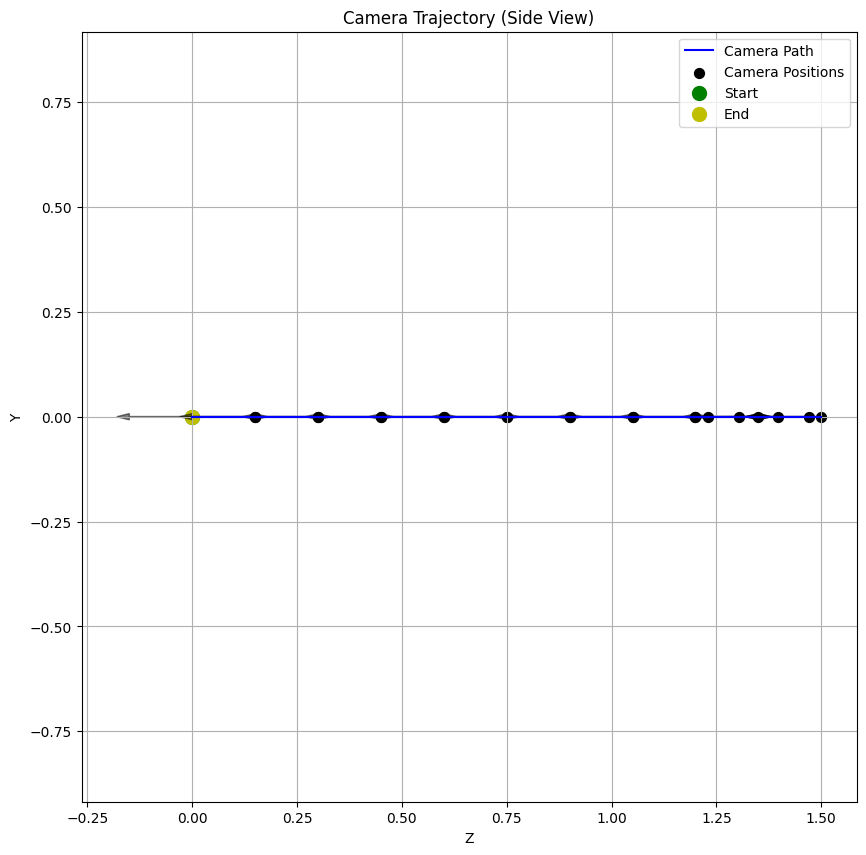

In [ ]:
# forward orbit backward trajectory within a loop closing window
num_frames_forward=9
num_frames_orbit=6
num_frames_backward=11
step_size=0.15
height=1.5
orbit_radius=0.15
remove_overlapping_frames=True

forward_orbit_backward = generate_trajectory_forward_orbit_backward(num_frames_forward=num_frames_forward, num_frames_orbit=num_frames_orbit, num_frames_backward=num_frames_backward, step_size=step_size, height=height, orbit_radius=orbit_radius, remove_overlapping_frames=remove_overlapping_frames)

# visualize trajectory
plot_camera_trajectory_sideview(forward_orbit_backward)

# save trajectory as a video
frames = plot_camera_trajectory_topdown_video(forward_orbit_backward)

# save frames as video
name = "forward_orbit_backward_loop_closing_window"
save_frames_as_video(frames, "/data/scene-rep/u/ndsong/loop-consistency/{}.mp4".format(name))

# sample frames
sampled_indices = [18,19,4,5,6,7,16,17]

# save to data_dict
data_dict[name] = ([frames[i] for i in sampled_indices], forward_orbit_backward[sampled_indices])

###########################

# Take the videos and poses and save them into RE10K format
new_folder_base = "/data/scene-rep/u/ndsong/loop-consistency/data/"
new_config_dataset_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset/"
new_config_dataset_experiment_base = "/data/scene-rep/u/ndsong/loop-consistency/configurations/dataset_experiment/"

# create new folder
new_folder = new_folder_base + name
os.makedirs(new_folder, exist_ok=True)

# create subdirectories for videos and poses
video_dirs = ["test_256", "training_256"]
pose_dirs = ["test_poses", "training_poses"]

for directory in video_dirs + pose_dirs:
    os.makedirs(os.path.join(new_folder, directory), exist_ok=True)

# create the necessary config files for each case
# To do so, we need to copy the template config file for dataset and dataset_experiment
# and then we need to modify the "save_dir" field in the dataset config file
# 1) copy the template config file for dataset and dataset_experiment
shutil.copy(new_config_dataset_base + "benchmark_trajectory_template.yaml", new_config_dataset_base + name + ".yaml")
shutil.copy(new_config_dataset_experiment_base + "benchmark_trajectory_template_video_generation.yaml", new_config_dataset_experiment_base + name + "_video_generation.yaml")

# 2) modify the "save_dir" field in the dataset config file
with open(new_config_dataset_base + name + ".yaml", "r") as file:
    dataset_config = yaml.load(file, Loader=yaml.SafeLoader)
dataset_config["save_dir"] = "data/" + name                             # 
with open(new_config_dataset_base + name + ".yaml", "w") as file:
    yaml.dump(dataset_config, file)

# create 100 copies of each kind of dataset with the following intrinsics
intrinsics = [0.4969, 0.8834, 0.5000, 0.5000]

for video_id in range(100):
    
    if name not in data_dict:
        print(f"Dataset {name} not found")
        continue

    frames, poses = data_dict[name]
    save_video_and_poses(frames, poses, intrinsics, new_folder_base + name, "{:05d}".format(video_id))